In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from tqdm import tqdm

from gensim.models import KeyedVectors

import multiprocessing as mp
from spacy.tokens import Doc
from typing import List

In [ ]:
data_path = "/content/drive/MyDrive/data/data/"

dmeeting = pd.read_parquet(data_path + 'data_meeting.parquet')
data_agenda1 = pd.read_parquet(data_path + 'data_agenda1.parquet')
data_agenda2 = pd.read_parquet(data_path + 'data_agenda2.parquet')
data_agenda3 = pd.read_parquet(data_path + 'data_agenda3.parquet')
data_speech1 = pd.read_parquet(data_path + 'data_speech1.parquet')
data_speech2 = pd.read_parquet(data_path + 'data_speech2.parquet')
data_speech3 = pd.read_parquet(data_path + 'data_speech3.parquet')
parMem = pd.read_parquet(data_path + 'parliament_members.parquet')

#dagenda = pd.concat([data_agenda1, data_agenda2, data_agenda3], axis=0)
#dspeech = pd.concat([data_speech1, data_speech2, data_speech3], axis=0)

annotation_data = pd.read_csv(data_path + 'annotation_data.csv')

In [ ]:
df1 = data_speech1[~data_speech1[['meeting_id', 'agenda_item_id']].apply(tuple, axis=1).isin(annotation_data[['meeting_id', 'agenda_item_id']].apply(tuple, axis=1))]
df2 = data_speech2[~data_speech2[['meeting_id', 'agenda_item_id']].apply(tuple, axis=1).isin(annotation_data[['meeting_id', 'agenda_item_id']].apply(tuple, axis=1))]
df3 = data_speech3[~data_speech3[['meeting_id', 'agenda_item_id']].apply(tuple, axis=1).isin(annotation_data[['meeting_id', 'agenda_item_id']].apply(tuple, axis=1))]

In [139]:
df_anno = pd.read_csv(data_path + 'labeled_tokenized_data.csv')

In [ ]:
df1.describe()

,meeting_id,agenda_item_id,speech_item_id,duration,number_of_words
count,110971.000000,110971.000000,110971.000000,110971.000000,110971.000000
mean,289.820908,10.586640,99.200232,73.953853,218.450451
std,171.919644,9.847637,168.289659,68.057119,230.719927
min,1.000000,1.000000,1.000000,0.000000,1.000000
25%,143.000000,3.000000,12.000000,37.000000,109.000000
50%,273.000000,8.000000,40.000000,55.000000,163.000000
75%,441.500000,15.000000,106.000000,75.000000,228.000000
max,598.000000,76.000000,1367.000000,613.000000,5482.000000


In [ ]:
!python3 -m spacy download 'da_core_news_sm'

2023-11-30 14:58:42.285325: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-30 14:58:42.285379: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-30 14:58:42.285409: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-30 14:58:43.531470: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 27.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('da_core_news_sm')


In [ ]:
nlp = spacy.load("da_core_news_sm")
exception_list = ['CO2', 'co2']

def preprocess_text(doc: Doc) -> List[str]:
    processed_tokens = [token.text.lower() for token in doc if not token.is_stop and token.is_alpha or token.text in exception_list]
    return processed_tokens

# Use spaCy's pipe method to process text in batches
texts = df1.speech_item_text.values.tolist()
docs = list(nlp.pipe(texts, n_process=16))  # Use multiprocessing

# Apply the text processing functions
df1['processed_tokens'] = [preprocess_text(doc) for doc in docs]
df1.to_csv(data_path + '/tokenized_df1.csv', index=False)

texts = df2.speech_item_text.values.tolist()
docs = list(nlp.pipe(texts, n_process=16))

df2['processed_tokens'] = [preprocess_text(doc) for doc in docs]
df2.to_csv(data_path + '/tokenized_df2.csv', index=False)

texts = df3.speech_item_text.values.tolist()
docs = list(nlp.pipe(texts, n_process=16))

df3['processed_tokens'] = [preprocess_text(doc) for doc in docs]
df3.to_csv(data_path + '/tokenized_df3.csv', index=False)

<ipython-input-7-5e9aa746a76a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['processed_tokens'] = [preprocess_text(doc) for doc in docs]


### Feature Engineering

In [138]:
data_path = "/content/drive/MyDrive/data/data/"

In [103]:
import pickle

file_path = 'generic_words_list.pkl'
with open(data_path+file_path, 'rb') as file:
    generic_words_list = pickle.load(file)
    generic_words_set = set(generic_words_list)

file_path = 'C_words_list.pkl'
with open(data_path+file_path, 'rb') as file:
    C_words_list = pickle.load(file)
    C_words_set = set(C_words_list)

file_path = 'NC_words_list.pkl'
with open(data_path+file_path, 'rb') as file:
    NC_words_list = pickle.load(file)
    NC_words_set = set(NC_words_list)

file_path = 'extra_C_words_list.pkl'
with open(data_path+file_path, 'rb') as file:
    extra_C_words_list = pickle.load(file)
    extra_C_words_set = set(extra_C_words_list)

file_path = 'extra_NC_words_list.pkl'
with open(data_path+file_path, 'rb') as file:
    extra_NC_words_list = pickle.load(file)
    extra_NC_words_set = set(extra_NC_words_list)

In [ ]:
df1 = pd.read_csv(data_path+"train_df1.csv")
df2 = pd.read_csv(data_path+"train_df2.csv")
df3 = pd.read_csv(data_path+"train_df3.csv")

In [ ]:
from gensim.models import KeyedVectors
MODEL_FILE = 'dsl_skipgram_2020_m5_f500_epoch2_w5.model.w2v.bin'
model = KeyedVectors.load_word2vec_format(data_path+MODEL_FILE, binary=True)

In [ ]:
for df in [df1, df2, df3]:
  count_list = []
  speech_list = []
  word_vec_list = []

  tokenized_list = df.tokenized_speech.to_list()
  #tokenized_list = df.processed_tokens.to_list() ### for df_anno
  for i in tokenized_list:
    C_counts = 0
    NC_counts = 0
    average_vec = 0

    tokenized = eval(i)
    token_len = len(tokenized)
    for word in tokenized:
      if word in generic_words_set:
        token_len -= 1
      else:
        if word in C_words_set:
          C_counts += 1
        elif word in NC_words_set:
          NC_counts += 1
        elif word in extra_C_words_set:
          C_counts += 1
        elif word in extra_NC_words_set:
          NC_counts += 1


        try:
          vec = model.get_vector(word)
          average_vec += vec
        except:
          token_len -= 1

    count_list.append([C_counts, NC_counts, token_len])
    speech_list.append(tokenized)
    if token_len != 0:
      average_vec = average_vec/token_len
    else:
      average_vec = np.zeros((500,), dtype=int)
    word_vec_list.append(average_vec)

  df[["C_counts", "NC_counts", "counts"]] = count_list
  df["tokenized_speech"] = speech_list

  df["C_percent"] = 100 * df["C_counts"] / df["counts"]
  df["NC_percent"] = 100 * df["NC_counts"] / df["counts"]

  df["average_vec"] = word_vec_list

### Pick a Threshold

In [ ]:
### with extra C words
df1[(df1.C_counts>2)&(df1.NC_counts==0)].describe()

,prediction_C,C_counts,NC_counts,counts,C_percent,NC_percent
count,3389.000000,3389.000000,3389.0,3389.000000,3389.000000,3389.0
mean,0.894263,6.580997,0.0,79.451166,10.230664,0.0
std,0.216690,6.130252,0.0,71.473365,5.818042,0.0
min,0.000518,3.000000,0.0,9.000000,0.497512,0.0
25%,0.919702,3.000000,0.0,39.000000,6.153846,0.0
50%,0.991618,5.000000,0.0,54.000000,9.090909,0.0
75%,0.998440,7.000000,0.0,87.000000,12.903226,0.0
max,0.999887,81.000000,0.0,766.000000,50.000000,0.0


In [ ]:
### without extra C words
df1[(df1.C_counts>1)&(df1.NC_counts==0)].describe()

,prediction_C,C_counts,NC_counts,counts,C_percent,NC_percent
count,1677.000000,1677.000000,1677.0,1677.000000,1677.000000,1677.0
mean,0.966494,3.784735,0.0,99.883125,5.451728,0.0
std,0.059779,3.121189,0.0,91.396717,3.801902,0.0
min,0.771408,2.000000,0.0,7.000000,0.353982,0.0
25%,0.970546,2.000000,0.0,42.000000,2.840909,0.0
50%,0.996029,3.000000,0.0,61.000000,4.556962,0.0
75%,0.999165,4.000000,0.0,129.000000,7.017544,0.0
max,0.999887,46.000000,0.0,670.000000,28.571429,0.0


In [ ]:
### with extra NC words
df1[(df1.NC_counts>2)&(df1.C_counts==0)].describe()

,prediction_C,C_counts,NC_counts,counts,C_percent,NC_percent
count,29175.000000,29175.0,29175.000000,29175.000000,29175.0,29175.000000
mean,0.002583,0.0,7.257823,97.379400,0.0,9.282289
std,0.020848,0.0,7.146329,93.664543,0.0,5.349783
min,0.000015,0.0,3.000000,5.000000,0.0,0.408719
25%,0.000066,0.0,3.000000,44.000000,0.0,5.555556
50%,0.000172,0.0,5.000000,61.000000,0.0,8.163265
75%,0.000608,0.0,8.000000,111.000000,0.0,11.764706
max,0.891510,0.0,147.000000,1238.000000,0.0,60.000000


In [ ]:
### without extra NC words
df1[(df1.NC_counts>2)&(df1.C_counts==0)].describe()

,prediction_C,C_counts,NC_counts,counts,C_percent,NC_percent
count,17271.000000,17271.0,17271.000000,17271.000000,17271.0,17271.000000
mean,0.001103,0.0,6.247583,126.415668,0.0,6.938815
std,0.008742,0.0,5.493152,121.597833,0.0,4.394745
min,0.000015,0.0,3.000000,6.000000,0.0,0.440529
25%,0.000048,0.0,3.000000,50.000000,0.0,3.896104
50%,0.000108,0.0,4.000000,73.000000,0.0,6.097561
75%,0.000337,0.0,7.000000,172.000000,0.0,8.928571
max,0.227758,0.0,99.000000,1513.000000,0.0,50.000000


In [ ]:
df_C = df1.loc[(df1.C_counts>1)&(df1.NC_counts==0), ["average_vec", "C_percent", "NC_percent"]]
df_C["label"] = "C"

In [ ]:
df_NC = df1.loc[(df1.NC_counts>2)&(df1.C_counts==0), ["average_vec", "C_percent", "NC_percent"]]
df_NC["label"] = "NC"

In [ ]:
df_test = pd.concat([df_C, df_NC])
df_temp = df_test['average_vec'].apply(lambda x: pd.Series(x))
df_test = pd.concat([df_temp, df_test["label"]], axis=1).reset_index(drop=True)

In [ ]:
df_test

,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,label
0,-0.102976,-0.041083,-0.001222,-0.080776,-0.032347,0.060810,-0.013175,-0.027007,0.114586,-0.041932,...,0.049337,-0.030871,0.080914,-0.002156,-0.080179,0.019267,-0.001811,0.009271,0.025459,C
1,-0.056322,0.014096,-0.019239,-0.069398,-0.068590,0.015294,0.017578,-0.085744,0.113956,0.000107,...,0.050116,-0.085196,0.070572,0.002885,-0.119398,-0.026409,-0.068646,0.038578,0.040653,C
2,-0.055454,0.015200,0.014425,-0.124528,-0.071424,0.066901,-0.110617,0.043566,0.114616,-0.113456,...,0.098969,-0.066474,0.102061,-0.018021,-0.088574,0.061590,-0.085908,0.005623,0.084426,C
3,-0.105017,0.048927,-0.049682,-0.118646,-0.078856,0.080188,-0.101986,-0.015298,0.132439,-0.007498,...,0.115574,-0.131573,0.095502,-0.016828,-0.158774,0.040090,-0.048720,-0.033552,0.035838,C
4,-0.066423,-0.002033,0.058461,-0.074273,-0.047170,0.100616,-0.063186,-0.023757,0.099987,-0.044758,...,0.077782,-0.091569,-0.003931,-0.030284,-0.120801,0.026381,-0.029602,-0.018373,-0.035021,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18943,-0.077828,-0.028488,0.101229,-0.134083,-0.041859,-0.002757,-0.073553,0.034550,0.142912,-0.071333,...,0.075507,-0.097566,-0.028434,-0.048625,-0.153852,0.045156,-0.077737,0.028919,0.017873,NC
18944,-0.023730,-0.052630,0.074979,-0.144234,0.008911,0.007832,-0.107222,0.022394,0.157644,-0.101477,...,0.121616,-0.045649,-0.009455,-0.034675,-0.144007,-0.018312,-0.062547,-0.009292,-0.009292,NC
18945,-0.123257,-0.003973,0.089525,-0.107326,-0.094557,0.048098,-0.058256,-0.037406,0.076646,-0.084519,...,0.129369,-0.068464,0.021902,0.058688,-0.150139,0.049447,-0.035381,-0.024423,0.047139,NC
18946,-0.025397,-0.010444,0.041848,-0.083890,-0.050753,0.035918,-0.007309,-0.000668,0.116698,-0.062388,...,0.068934,-0.055998,0.025715,0.011447,-0.173280,0.055148,-0.063493,-0.049040,0.002008,NC


### Train a Classification Model

In [28]:
!pip install lightgbm scikit-learn
!pip install joblib

In [ ]:
!pip3 install optuna
!pip3 install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.2 MB/s eta 0:00:00


[LightGBM] [Info] Number of positive: 13817, number of negative: 1341
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127500
[LightGBM] [Info] Number of data points in the train set: 15158, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.911532 -> initscore=2.332484
[LightGBM] [Info] Start training from score 2.332484
Loss for fold 1: 0.045719549473019885
[LightGBM] [Info] Number of positive: 13817, number of negative: 1341
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127500
[LightGBM] [Info] Number of data points in the train set: 15158, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.911532 -> initscore=2.332484
[LightGBM] [Info] Start tra

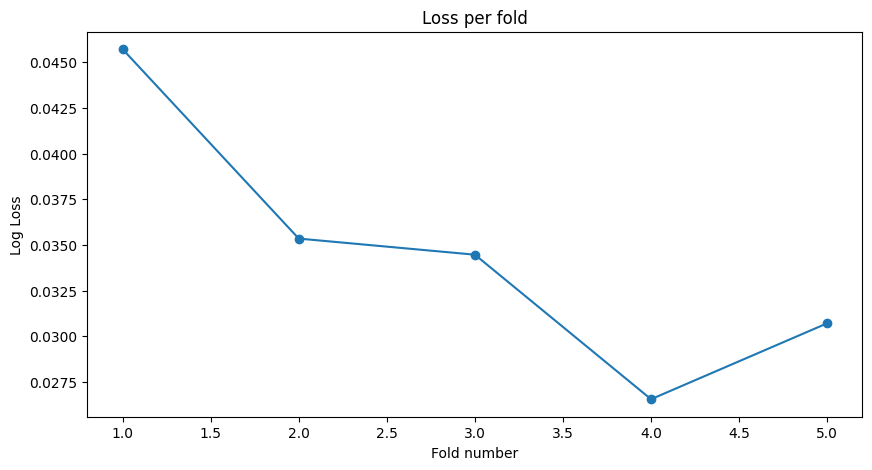

In [ ]:
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, log_loss
import joblib

# Assuming df is your DataFrame and it has a column named 'label'
X = df_test.drop("label", axis=1)  # replace 'features' with your actual feature columns
y = df_test['label']

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

loss_values = []
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Initialize LGBMClassifier
    model = lgb.LGBMClassifier()

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict_proba(X_test)

    # Calculate loss
    loss = log_loss(y_test, y_pred)
    loss_values.append(loss)
    print(f'Loss for fold {i+1}: {loss}')

    # Save the model
    joblib.dump(model, data_path+f'model_fold_{i+1}.joblib')

# Plot the loss values
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o')
plt.title('Loss per fold')
plt.xlabel('Fold number')
plt.ylabel('Log Loss')
plt.show()

[I 2023-12-02 09:42:45,727] A new study created in memory with name: LGBM Classifier


[LightGBM] [Info] Number of positive: 13817, number of negative: 1342
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127500
[LightGBM] [Info] Number of data points in the train set: 15159, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.911472 -> initscore=2.331739
[LightGBM] [Info] Start training from score 2.331739
Testing accuracy 0.0405
[LightGBM] [Info] Number of positive: 13817, number of negative: 1342
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127500
[LightGBM] [Info] Number of data points in the train set: 15159, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.911472 -> initscore=2.331739
[LightGBM] [Info] Start training from sco

[I 2023-12-02 09:43:31,608] Trial 0 finished with value: 0.040513880266184334 and parameters: {'learning_rate': 0.10047835849360848, 'n_estimators': 173, 'num_leaves': 43}. Best is trial 0 with value: 0.040513880266184334.


Testing accuracy 0.0405
[LightGBM] [Info] Number of positive: 13817, number of negative: 1342
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127500
[LightGBM] [Info] Number of data points in the train set: 15159, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.911472 -> initscore=2.331739
[LightGBM] [Info] Start training from score 2.331739
Testing accuracy 0.0368
[LightGBM] [Info] Number of positive: 13817, number of negative: 1342
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127500
[LightGBM] [Info] Number of data points in the train set: 15159, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.911472 -> initscore=2.331739
[LightGBM] [Info]

[I 2023-12-02 09:44:10,270] Trial 1 finished with value: 0.036778759315435255 and parameters: {'learning_rate': 0.12334540693027787, 'n_estimators': 182, 'num_leaves': 31}. Best is trial 1 with value: 0.036778759315435255.


Testing accuracy 0.0368
[LightGBM] [Info] Number of positive: 13817, number of negative: 1342
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127500
[LightGBM] [Info] Number of data points in the train set: 15159, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.911472 -> initscore=2.331739
[LightGBM] [Info] Start training from score 2.331739
Testing accuracy 0.0384
[LightGBM] [Info] Number of positive: 13817, number of negative: 1342
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127500
[LightGBM] [Info] Number of data points in the train set: 15159, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.911472 -> initscore=2.331739
[LightGBM] [Info]

[I 2023-12-02 09:44:52,890] Trial 2 finished with value: 0.03836926851516371 and parameters: {'learning_rate': 0.10146288315556584, 'n_estimators': 141, 'num_leaves': 48}. Best is trial 1 with value: 0.036778759315435255.


Testing accuracy 0.0384
[LightGBM] [Info] Number of positive: 13817, number of negative: 1342
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127500
[LightGBM] [Info] Number of data points in the train set: 15159, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.911472 -> initscore=2.331739
[LightGBM] [Info] Start training from score 2.331739
Testing accuracy 0.0342
[LightGBM] [Info] Number of positive: 13817, number of negative: 1342
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127500
[LightGBM] [Info] Number of data points in the train set: 15159, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.911472 -> initscore=2.331739
[LightGBM] [Info]

[I 2023-12-02 09:45:26,369] Trial 3 finished with value: 0.03424472714485953 and parameters: {'learning_rate': 0.14705826862879604, 'n_estimators': 151, 'num_leaves': 31}. Best is trial 3 with value: 0.03424472714485953.


Testing accuracy 0.0342
[LightGBM] [Info] Number of positive: 13817, number of negative: 1342
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127500
[LightGBM] [Info] Number of data points in the train set: 15159, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.911472 -> initscore=2.331739
[LightGBM] [Info] Start training from score 2.331739
Testing accuracy 0.0400
[LightGBM] [Info] Number of positive: 13817, number of negative: 1342
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127500
[LightGBM] [Info] Number of data points in the train set: 15159, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.911472 -> initscore=2.331739
[LightGBM] [Info]

[I 2023-12-02 09:46:03,807] Trial 4 finished with value: 0.03996895136270863 and parameters: {'learning_rate': 0.1298908254171165, 'n_estimators': 119, 'num_leaves': 50}. Best is trial 3 with value: 0.03424472714485953.


Testing accuracy 0.0400
[LightGBM] [Info] Number of positive: 13817, number of negative: 1342
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.181050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127500
[LightGBM] [Info] Number of data points in the train set: 15159, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.911472 -> initscore=2.331739
[LightGBM] [Info] Start training from score 2.331739
Testing accuracy 0.0394
[LightGBM] [Info] Number of positive: 13817, number of negative: 1342
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127500
[LightGBM] [Info] Number of data points in the train set: 15159, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.911472 -> initscore=2.331739
[LightGBM] [Info]

[I 2023-12-02 09:46:38,899] Trial 5 finished with value: 0.03936314948448997 and parameters: {'learning_rate': 0.14190022590518866, 'n_estimators': 111, 'num_leaves': 48}. Best is trial 3 with value: 0.03424472714485953.


Testing accuracy 0.0394
[LightGBM] [Info] Number of positive: 13817, number of negative: 1342
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127500
[LightGBM] [Info] Number of data points in the train set: 15159, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.911472 -> initscore=2.331739
[LightGBM] [Info] Start training from score 2.331739
Testing accuracy 0.0405
[LightGBM] [Info] Number of positive: 13817, number of negative: 1342
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127500
[LightGBM] [Info] Number of data points in the train set: 15159, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.911472 -> initscore=2.331739
[LightGBM] [Info]

[I 2023-12-02 09:47:12,378] Trial 6 finished with value: 0.04049692969996354 and parameters: {'learning_rate': 0.1357481944278002, 'n_estimators': 131, 'num_leaves': 38}. Best is trial 3 with value: 0.03424472714485953.


Testing accuracy 0.0405
[LightGBM] [Info] Number of positive: 13817, number of negative: 1342
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127500
[LightGBM] [Info] Number of data points in the train set: 15159, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.911472 -> initscore=2.331739
[LightGBM] [Info] Start training from score 2.331739
Testing accuracy 0.0352
[LightGBM] [Info] Number of positive: 13817, number of negative: 1342
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127500
[LightGBM] [Info] Number of data points in the train set: 15159, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.911472 -> initscore=2.331739
[LightGBM] [Info]

[I 2023-12-02 09:47:44,536] Trial 7 finished with value: 0.03515094081099097 and parameters: {'learning_rate': 0.11391623587733633, 'n_estimators': 112, 'num_leaves': 42}. Best is trial 3 with value: 0.03424472714485953.


Testing accuracy 0.0352
[LightGBM] [Info] Number of positive: 13817, number of negative: 1342
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127500
[LightGBM] [Info] Number of data points in the train set: 15159, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.911472 -> initscore=2.331739
[LightGBM] [Info] Start training from score 2.331739
Testing accuracy 0.0351
[LightGBM] [Info] Number of positive: 13817, number of negative: 1342
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127500
[LightGBM] [Info] Number of data points in the train set: 15159, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.911472 -> initscore=2.331739
[LightGBM] [Info]

[I 2023-12-02 09:48:21,475] Trial 8 finished with value: 0.03510421403094088 and parameters: {'learning_rate': 0.12775520096561283, 'n_estimators': 161, 'num_leaves': 33}. Best is trial 3 with value: 0.03424472714485953.


Testing accuracy 0.0351
[LightGBM] [Info] Number of positive: 13817, number of negative: 1342
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127500
[LightGBM] [Info] Number of data points in the train set: 15159, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.911472 -> initscore=2.331739
[LightGBM] [Info] Start training from score 2.331739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2023-12-02 09:49:05,425] Trial 9 finished with value: 0.040304412030308046 and parameters: {'learning_rate': 0.1365941333877817, 'n_estimators': 187, 'num_leaves': 40}. Best is trial 3 with value: 0.03424472714485953.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Testing accuracy 0.0403
[LightGBM] [Info] Number of positive: 13817, number of negative: 1341
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127500
[LightGBM] [Info] Number of data points in the train set: 15158, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.911532 -> initscore=2.332484
[LightGBM] [Info] Start training from score 2.332484
Loss for fold 1: 0.06130608314062457
[LightGBM] [Info] Number of positive: 13817, number of negative: 1341
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065337 seconds.
You can set `force_col_wise=true` to remove th

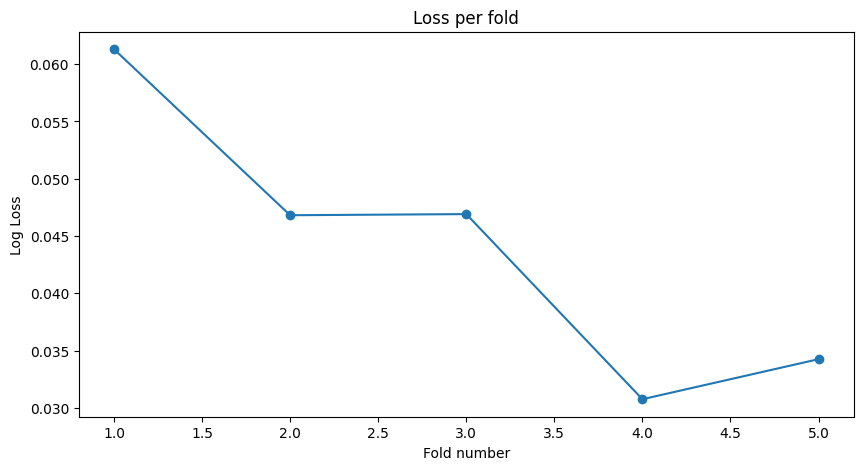

In [ ]:
import lightgbm as lgb
import optuna
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, log_loss
import joblib

def objective(trial, X, y, cv):
    """
    Objective function to be minimized.
    """
    params = {
        'boosting_type': 'gbdt',
        'class_weight': None,
        'colsample_bytree': 1.0,
        'importance_type': 'split',
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 0.15),
        'max_depth': -1,
        'min_child_samples': 20,
        'min_child_weight': 0.001,
        'min_split_gain': 0.0,
        'n_estimators': trial.suggest_int('n_estimators', 100, 200),
        'n_jobs': None,
        'num_leaves': trial.suggest_int('num_leaves', 31, 50),
        'objective': None,
        'random_state': None,
        'reg_alpha': 0.0,
        'reg_lambda': 0.0,
        'subsample': 1.0,
        'subsample_for_bin': 200000,
        'subsample_freq': 0,
    }

    cv_scores = np.empty(5)

    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        gbm = lgb.LGBMClassifier(**params)
        gbm.fit(X_train, y_train)
        preds = gbm.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)
        print("Testing accuracy {:.4f}".format(cv_scores[idx]))

    return np.mean(cv_scores)

# Assuming df is your DataFrame and it has a column named 'label'
X = df_test.drop("label", axis=1)  # replace 'features' with your actual feature columns
y = df_test['label']

# Initialize StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X, y, cv)
study.optimize(func, n_trials=10)


loss_values = []
for i, (train_index, test_index) in enumerate(cv.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Initialize LGBMClassifier
    model = lgb.LGBMClassifier(**study.best_params)

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict_proba(X_test)

    # Calculate loss
    loss = log_loss(y_test, y_pred)
    loss_values.append(loss)
    print(f'Loss for fold {i+1}: {loss}')

    # Save the model
    joblib.dump(model, data_path+f'optimized_model_fold_{i+1}.joblib')

# Plot the loss values
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o')
plt.title('Loss per fold')
plt.xlabel('Fold number')
plt.ylabel('Log Loss')
plt.show()

In [ ]:
study.best_params

{'learning_rate': 0.14705826862879604, 'n_estimators': 151, 'num_leaves': 31}

### Check Annotated Data

In [ ]:
df_anno_temp = df_anno['average_vec'].apply(lambda x: pd.Series(x))

In [ ]:
models = []
for i in range(5):
    models.append(joblib.load(data_path+f'model_fold_{i+1}.joblib'))

predictions = []
for model in models:
    predictions.append(model.predict_proba(df_anno_temp))

df_anno[['prediction_C', 'prediction_NC']] = np.mean(predictions, axis=0)

In [ ]:
models = []
for i in range(5):
    models.append(joblib.load(data_path+f'optimized_model_fold_{i+1}.joblib'))

predictions = []
for model in models:
    predictions.append(model.predict_proba(df_anno_temp))

df_anno[['opt_prediction_C', 'opt_prediction_NC']] = np.mean(predictions, axis=0)

In [ ]:
df_anno[df_anno.label_agenda=="NC"].describe()

,C_counts,NC_counts,counts,C_percent,NC_percent,opt_prediction_C,opt_prediction_NC,prediction_C,prediction_NC
count,35423.000000,35423.000000,35423.000000,35418.000000,35418.000000,3.542300e+04,3.542300e+04,35423.000000,35423.000000
mean,0.021370,1.575982,76.475934,0.026271,1.856526,6.230432e-02,9.376957e-01,0.073104,0.926896
std,0.242138,3.672037,88.846781,0.326964,3.025918,2.010817e-01,2.010817e-01,0.190909,0.190909
min,0.000000,0.000000,0.000000,0.000000,0.000000,9.082339e-10,2.462548e-08,0.000015,0.000148
25%,0.000000,0.000000,36.000000,0.000000,0.000000,1.006271e-06,9.971360e-01,0.000330,0.971814
50%,0.000000,0.000000,52.000000,0.000000,0.000000,4.252698e-05,9.999575e-01,0.002639,0.997361
75%,0.000000,2.000000,76.000000,0.000000,2.816901,2.863995e-03,9.999990e-01,0.028186,0.999670
max,17.000000,83.000000,2294.000000,20.000000,50.000000,1.000000e+00,1.000000e+00,0.999852,0.999985


In [ ]:
df_anno[df_anno.label_agenda=="C"].describe()

,C_counts,NC_counts,counts,C_percent,NC_percent,prediction_C,prediction_NC
count,2271.000000,2271.000000,2271.000000,2271.000000,2271.000000,2271.000000,2271.000000
mean,1.729635,0.054161,63.208278,2.572924,0.089157,0.599204,0.400796
std,3.569202,0.281858,69.394640,3.984437,0.571068,0.396623,0.396623
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000020,0.000117
25%,0.000000,0.000000,28.000000,0.000000,0.000000,0.150552,0.013817
50%,0.000000,0.000000,41.000000,0.000000,0.000000,0.751478,0.248522
75%,2.000000,0.000000,62.000000,4.081633,0.000000,0.986183,0.849448
max,55.000000,5.000000,690.000000,30.303030,9.090909,0.999883,0.999980


In [ ]:
df_anno[(df_anno.label_agenda=="C")&(df_anno.prediction_C<0.1)].iloc[0]["tokenized_speech"]

['selvfølgelig',
 'vanskeligt',
 'filosofere',
 'hjælpe',
 'obama',
 'når',
 'ser',
 'nuværende',
 'situation',
 'tror',
 'når',
 'ser',
 'klimaforhandlingerne',
 'amerikanerne',
 'primært',
 'kigger',
 'europæerne',
 'kineserne',
 'kineserne',
 'felt',
 'hensyn',
 'fiasko',
 'tage',
 'lang',
 'debat',
 'altså',
 'tilfældigvis',
 'kina',
 'indien',
 'rejse',
 'konstatere',
 'indtrykket',
 'glasset',
 'set',
 'halvt',
 'fyldt',
 'halvt',
 'tomt',
 'eventuelt',
 'komme',
 'når',
 'taler',
 'eu',
 'holdningen',
 'altså',
 'spille',
 'kort',
 'lægge',
 'kort',
 'bordet',
 'effekt',
 'kort',
 'spille',
 'netop',
 'lande',
 'gå',
 'når',
 'frem',
 'forhandlingsprocessen',
 'slet',
 'slet',
 'kommet',
 'forhandlingsbordet',
 'københavn',
 'ganske',
 'hurtigt',
 'proces',
 'prøve',
 'lykkes',
 'overbevist',
 'lande',
 'gå',
 'minder',
 'fællesskab',
 'bare',
 'står',
 'verdens',
 'samlede',
 'altså',
 'grænser',
 'eu',
 'bare',
 'gå',
 'solo',
 'set',
 'egentlig',
 'enig',
 'budskabet',
 'bare

In [ ]:
#del df_anno['C_counts'], df_anno['C_percent'], df_anno['NC_counts'], df_anno['NC_percent'], df_anno["counts"], df_anno["average_vec"], df_anno["prediction_NC"], df_anno["tokenized_speech"], df_anno["processed_tokens_lemma"]

In [ ]:
df_anno

,label_agenda,processed_tokens,id,prediction_C
0,C,"['spørgsmålet', 'lyder', 'ministeren', 'statsm...",22_16_2,0.211540
1,C,"['tak', 'spørgsmålet', 'starte', 'slå', 'fast'...",22_16_4,0.309277
2,C,"['virkeligheden', 'kloden', 'behov', 'initiati...",22_16_6,0.862134
3,C,"['selvfølgelig', 'vanskeligt', 'filosofere', '...",22_16_8,0.009790
4,C,"['jamen', 'virkeligheden', 'netop', 'står', 'f...",22_16_10,0.108858
...,...,...,...,...
37689,NC,"['indrømme', 'står', 'forsøger', 'kreativ', 'h...",1787_16_2,0.053238
37690,NC,"['medgiver', 'forvirrende', 'foregående', 'spø...",1787_16_4,0.205199
37691,NC,"['forventer', 'møde', 'afholdes', 'inden', 'må...",1787_16_6,0.357741
37692,NC,"['bare', 'ministeren', 'nuværende', 'tidspunkt...",1787_16_8,0.003052


In [ ]:
from sklearn.metrics import confusion_matrix

thresholds = [0.2, 0.3, 0.4, 0.5, 0.6]

for threshold in thresholds:
  df_anno["label_predicted"] = df_anno["prediction_C"].apply(lambda x: "C" if x >= threshold else "NC")

  cm = confusion_matrix(df_anno.label_agenda.to_list(), df_anno.label_predicted.to_list())
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  print(f"Confusion Matrix with threshold {threshold}:")
  print(cm)
  print(f"Confusion Matrix (Normalized by row sums) with threshold {threshold}:")
  print(cm_normalized)

Confusion Matrix with threshold 0.2:
[[ 1632   639]
 [ 3679 31744]]
Confusion Matrix (Normalized by row sums) with threshold 0.2:
[[0.71862616 0.28137384]
 [0.10385907 0.89614093]]
Confusion Matrix with threshold 0.3:
[[ 1508   763]
 [ 2804 32619]]
Confusion Matrix (Normalized by row sums) with threshold 0.3:
[[0.66402466 0.33597534]
 [0.07915761 0.92084239]]
Confusion Matrix with threshold 0.4:
[[ 1412   859]
 [ 2230 33193]]
Confusion Matrix (Normalized by row sums) with threshold 0.4:
[[0.62175253 0.37824747]
 [0.06295345 0.93704655]]
Confusion Matrix with threshold 0.5:
[[ 1325   946]
 [ 1844 33579]]
Confusion Matrix (Normalized by row sums) with threshold 0.5:
[[0.58344342 0.41655658]
 [0.05205657 0.94794343]]
Confusion Matrix with threshold 0.6:
[[ 1240  1031]
 [ 1532 33891]]
Confusion Matrix (Normalized by row sums) with threshold 0.6:
[[0.54601497 0.45398503]
 [0.04324874 0.95675126]]


In [ ]:
df_anno.to_csv(data_path + '/df_anno.csv', index=False)

### An Attempt to Make Extra C Words List

In [ ]:
df1_temp = df1['average_vec'].apply(lambda x: pd.Series(x))
df2_temp = df2['average_vec'].apply(lambda x: pd.Series(x))
df3_temp = df3['average_vec'].apply(lambda x: pd.Series(x))

In [ ]:
models = []
for i in range(5):
    models.append(joblib.load(data_path+f'model_fold_{i+1}.joblib'))

predictions1 = []
predictions2 = []
predictions3 = []
for model in models:
    predictions1.append(model.predict_proba(df1_temp))
    predictions2.append(model.predict_proba(df2_temp))
    predictions3.append(model.predict_proba(df3_temp))

df1[['prediction_C', 'prediction_NC']] = np.mean(predictions1, axis=0)
df2[['prediction_C', 'prediction_NC']] = np.mean(predictions2, axis=0)
df3[['prediction_C', 'prediction_NC']] = np.mean(predictions3, axis=0)

In [ ]:
df1[(df1.prediction_C>0.9)&(df1.C_counts>0)&(df1.NC_counts==0)].describe()

,prediction_C,C_counts,NC_counts,counts,C_percent,NC_percent,prediction_NC
count,2341.000000,2341.000000,2341.0,2341.000000,2341.000000,2341.0,2341.000000
mean,0.986286,2.865442,0.0,88.161042,4.496352,0.0,0.013714
std,0.022310,2.964506,0.0,84.478916,3.688988,0.0,0.022310
min,0.900491,1.000000,0.0,4.000000,0.130548,0.0,0.000108
25%,0.984396,1.000000,0.0,38.000000,1.990050,0.0,0.000689
50%,0.996974,2.000000,0.0,55.000000,3.448276,0.0,0.003026
75%,0.999311,3.000000,0.0,105.000000,5.882353,0.0,0.015604
max,0.999892,46.000000,0.0,766.000000,28.571429,0.0,0.099509


In [ ]:
df1[(df1.prediction_C<0.1)&(df1.NC_counts>0)&(df1.C_counts==0)].describe()

,prediction_C,C_counts,NC_counts,counts,C_percent,NC_percent,prediction_NC
count,42690.000000,42690.0,42690.000000,42690.000000,42690.0,42690.000000,42690.000000
mean,0.003075,0.0,3.339190,86.353502,0.0,4.861039,0.996925
std,0.010083,0.0,4.252674,92.708468,0.0,3.927423,0.010083
min,0.000013,0.0,1.000000,2.000000,0.0,0.109290,0.900053
25%,0.000065,0.0,1.000000,38.000000,0.0,2.164502,0.998871
50%,0.000219,0.0,2.000000,55.000000,0.0,3.703704,0.999781
75%,0.001129,0.0,4.000000,87.000000,0.0,6.349206,0.999935
max,0.099947,0.0,99.000000,1513.000000,0.0,66.666667,0.999987


In [ ]:
df1_C = df1[(df1.prediction_C>0.9)&(df1.C_counts>0)&(df1.NC_counts==0)]
df2_C = df2[(df2.prediction_C>0.9)&(df2.C_counts>0)&(df2.NC_counts==0)]
df3_C = df3[(df3.prediction_C>0.9)&(df3.C_counts>0)&(df3.NC_counts==0)]

df1_NC = df1[(df1.prediction_C<0.1)&(df1.NC_counts>0)&(df1.C_counts==0)]
df2_NC = df2[(df2.prediction_C<0.1)&(df2.NC_counts>0)&(df2.C_counts==0)]
df3_NC = df3[(df3.prediction_C<0.1)&(df3.NC_counts>0)&(df3.C_counts==0)]

In [ ]:
df_C = pd.concat([df1_C, df2_C, df3_C])
df_NC = pd.concat([df1_NC, df2_NC, df3_NC])

In [ ]:
def caluculate_odds(freq1, freq2, word_count):
    if freq2 == 0:
        if freq1 == 0:
            return 0
        else:
            if freq1 > 0.0001:
              return 9999
            else:
              return 0
    else:
        if freq1 == 0:
            return 0
        else:
            return freq1/freq2

In [ ]:
from collections import Counter

unique_words_C_list = [word for tokens in df_C.tokenized_speech for word in tokens]
unique_words_NC_list = [word for tokens in df_NC.tokenized_speech for word in tokens]

unique_words_C_dict = Counter(unique_words_C_list)
unique_words_NC_dict = Counter(unique_words_NC_list)

unique_words_C_df = pd.DataFrame.from_dict(unique_words_C_dict, orient='index', columns=['word_count_C']).reset_index().rename(columns={'index': 'word'})
unique_words_NC_df = pd.DataFrame.from_dict(unique_words_NC_dict, orient='index', columns=['word_count_NC']).reset_index().rename(columns={'index': 'word'})

unique_words = pd.merge(unique_words_C_df, unique_words_NC_df, on='word', how='outer')
unique_words[['word_count_C', 'word_count_NC']] = unique_words[['word_count_C', 'word_count_NC']].fillna(0)
unique_words['frequency_C'] = unique_words['word_count_C'] / sum(unique_words_C_df['word_count_C'])
unique_words['frequency_NC'] = unique_words['word_count_NC'] / sum(unique_words_NC_df['word_count_NC'])
unique_words["odds_C"] = unique_words.apply(lambda row: caluculate_odds(row['frequency_C'], row['frequency_NC'], row['word_count_C']), axis=1)
unique_words["odds_NC"] = unique_words.apply(lambda row: caluculate_odds(row['frequency_NC'], row['frequency_C'], row['word_count_NC']), axis=1)

In [ ]:
unique_words

,word,word_count_C,word_count_NC,frequency_C,frequency_NC,odds_C,odds_NC
0,radikale,680.0,13114.0,0.000959,9.599349e-04,0.999080,1.000921
1,venstre,1635.0,30348.0,0.002306,2.221451e-03,1.038040,0.963354
2,siges,67.0,1105.0,0.000094,8.088517e-05,1.168258,0.855975
3,ros,49.0,785.0,0.000069,5.746141e-05,1.202687,0.831471
4,enhedslisten,1299.0,17916.0,0.001832,1.311438e-03,1.396994,0.715823
...,...,...,...,...,...,...,...
195592,fordelingerne,0.0,1.0,0.000000,7.319925e-08,0.000000,0.000000
195593,sygedagpengeopfølgningen,0.0,1.0,0.000000,7.319925e-08,0.000000,0.000000
195594,sygeområdet,0.0,1.0,0.000000,7.319925e-08,0.000000,0.000000
195595,culture,0.0,1.0,0.000000,7.319925e-08,0.000000,0.000000


In [ ]:
extra_C_words = unique_words[(unique_words.odds_C > 20) & (unique_words.frequency_C > 0.0001)].word.to_list()
extra_NC_words = unique_words[(unique_words.odds_NC > 10) & (unique_words.frequency_NC > 0.0001)].word.to_list()

In [ ]:
extra_C_words_list = []
extra_NC_words_list = []
for i in extra_C_words:
  if i not in C_words_set:
    extra_C_words_list.append(i)

for i in extra_NC_words:
  if i not in NC_words_set:
    extra_NC_words_list.append(i)

print(f"FOUND EXTRA {len(extra_C_words_list)} C WORDS!!!")
print(f"FOUND EXTRA {len(extra_NC_words_list)} NC WORDS!!!")

FOUND EXTRA 146 C WORDS!!!
FOUND EXTRA 92 NC WORDS!!!


In [ ]:
with open(data_path + 'extra_C_words_list.pkl', 'wb') as file:
    pickle.dump(extra_C_words_list, file)

with open(data_path + 'extra_NC_words_list.pkl', 'wb') as file:
    pickle.dump(extra_NC_words_list, file)

### Update rare C/NC words


In [25]:
import pickle

file_path = 'C_words.pkl'
with open(data_path+file_path, 'rb') as file:
    C_words = pickle.load(file)
    #C_words = set(C_words)

file_path = 'NC_words.pkl'
with open(data_path+file_path, 'rb') as file:
    NC_words = pickle.load(file)
    #NC_words = set(NC_words)

file_path = 'rare_C_words.pkl'
with open(data_path+file_path, 'rb') as file:
    rare_C_words = pickle.load(file)
    #rare_C_words = set(rare_C_words)

file_path = 'rare_NC_words.pkl'
with open(data_path+file_path, 'rb') as file:
    rare_NC_words = pickle.load(file)
    #rare_NC_words = set(rare_NC_words)

In [33]:
C_words

{'affald',
 'animalske',
 'anlæg',
 'anlægsloft',
 'areal',
 'arealer',
 'arter',
 'atomkraft',
 'befordringsfradraget',
 'benzin',
 'bilafgifterne',
 'biodiversitet',
 'biodiversiteten',
 'biogas',
 'biomasse',
 'brint',
 'brændeovne',
 'brændsler',
 'brændstof',
 'brændstoffer',
 'co2',
 'delmål',
 'diesel',
 'dieselbiler',
 'dong',
 'drikkevand',
 'drikkevandet',
 'drivhusgasser',
 'drivmidler',
 'egge',
 'el',
 'elbil',
 'elbiler',
 'elbilerne',
 'elektricitet',
 'elektrificering',
 'elektrificeringen',
 'energi',
 'energiafgifter',
 'energiafgifterne',
 'energiaftale',
 'energiaftalen',
 'energibesparelser',
 'energibesparende',
 'energieffektivitet',
 'energien',
 'energiforbrug',
 'energiforbruget',
 'energiforlig',
 'energiforliget',
 'energiformer',
 'energiforsyning',
 'energikilder',
 'energiministeren',
 'energiområdet',
 'energipolitik',
 'energipolitikken',
 'energipolitiske',
 'energy',
 'eyvind',
 'fjernvarme',
 'fodslæbende',
 'forsyningssikkerhed',
 'forurening',
 'fo

In [ ]:
extra_rare_C_words = unique_words[(unique_words.word_count_NC<3)&(unique_words.frequency_C >= 0.0001)].word.to_list()
extra_rare_NC_words = unique_words[(unique_words.word_count_C<3)&(unique_words.frequency_NC >= 0.0001)].word.to_list()
extra_C_words = unique_words[(unique_words.word_count_NC>2) & (unique_words.odds_C > 20) & (unique_words.frequency_C > 0.0001)].word.to_list()
extra_NC_words = unique_words[(unique_words.word_count_C>2) & (unique_words.odds_NC > 10) & (unique_words.frequency_NC > 0.0001)].word.to_list()

In [ ]:
print(len(rare_C_words))
print(len(rare_NC_words))
print(len(C_words))
print(len(NC_words))

33
91
94
14


In [ ]:
for (words1, words2) in [(rare_C_words, extra_rare_C_words), (rare_NC_words, extra_rare_NC_words), (C_words, extra_C_words), (NC_words, extra_NC_words)]:
  for word in words2:
    if word not in words1:
      words1.add(word)
  print(len(words1))

108
141
196
70


In [ ]:
for (words1, words2) in [(rare_C_words, C_words), (rare_NC_words, NC_words)]:
    words = list(words1)
    for word in words:
      if word in words2:
        words1.remove(word)
    print(len(words1))

57
126


In [ ]:
with open(data_path + 'rare_C_words.pkl', 'wb') as file:
    pickle.dump(rare_C_words, file)

with open(data_path + 'rare_NC_words.pkl', 'wb') as file:
    pickle.dump(rare_NC_words, file)

with open(data_path + 'C_words.pkl', 'wb') as file:
    pickle.dump(C_words, file)

with open(data_path + 'NC_words.pkl', 'wb') as file:
    pickle.dump(NC_words, file)

### Train Another Classifier Model

In [ ]:
df_anno

,label_agenda,processed_tokens,processed_tokens_lemma,id
0,C,"['spørgsmålet', 'lyder', 'ministeren', 'statsm...","['spørgsmål', 'lyde', 'minister', 'statsminist...",22_16_2
1,C,"['tak', 'spørgsmålet', 'starte', 'slå', 'fast'...","['tak', 'spørgsmål', 'starte', 'slå', 'fast', ...",22_16_4
2,C,"['virkeligheden', 'kloden', 'behov', 'initiati...","['virkelighed', 'klod', 'behov', 'initiativ', ...",22_16_6
3,C,"['selvfølgelig', 'vanskeligt', 'filosofere', '...","['selvfølgelig', 'vanskelig', 'filosofere', 'h...",22_16_8
4,C,"['jamen', 'virkeligheden', 'netop', 'står', 'f...","['jamen', 'virkelighed', 'netop', 'stå', 'fast...",22_16_10
...,...,...,...,...
37689,NC,"['indrømme', 'står', 'forsøger', 'kreativ', 'h...","['indrømme', 'stå', 'forsøge', 'kreativ', 'hen...",1787_16_2
37690,NC,"['medgiver', 'forvirrende', 'foregående', 'spø...","['medgive', 'forvirre', 'foregående', 'spørgsm...",1787_16_4
37691,NC,"['forventer', 'møde', 'afholdes', 'inden', 'må...","['forvente', 'møde', 'afholde', 'inden', 'måne...",1787_16_6
37692,NC,"['bare', 'ministeren', 'nuværende', 'tidspunkt...","['bare', 'minister', 'nuværende', 'tidspunkt',...",1787_16_8


In [140]:
for df in [df_anno]:
  count_list = []
  speech_list = []

  tokenized_list = df.processed_tokens.to_list() ### for df_anno
  for i in tokenized_list:
    rare_C_counts = 0
    rare_NC_counts = 0
    C_counts = 0
    NC_counts = 0
    generic_counts = 0

    tokenized = eval(i)
    token_len = len(tokenized)
    for word in tokenized:
      if word in rare_C_words:
        rare_C_counts += 1
      elif word in rare_NC_words:
        rare_NC_counts += 1
      elif word in C_words:
        C_counts += 1
      elif word in NC_words:
        NC_counts += 1
      elif word in generic_words_set:
        generic_counts += 1

    count_list.append([rare_C_counts, rare_NC_counts, C_counts, NC_counts, generic_counts, token_len])
    speech_list.append(tokenized)

  df[["rare_C_counts", "rare_NC_counts", "C_counts", "NC_counts", "gen_counts", "counts"]] = count_list
  df["tokenized_speech"] = speech_list

  df["C_percent"] = 100 * df['C_counts'] / df["counts"]
  df["NC_percent"] = 100 * df['NC_counts'] / df["counts"]
  df["weighted_C_percent"] = 100 * df['C_counts'] / (df["counts"] - df["gen_counts"])
  df["weighted_NC_percent"] = 100 * df['NC_counts'] / (df["counts"] - df["gen_counts"])

In [143]:
df_anno[(df_anno.label_agenda=="C")&((df_anno.rare_C_counts!=0)|(df_anno.C_counts!=0))].describe()

,rare_C_counts,rare_NC_counts,C_counts,NC_counts,gen_counts,counts,C_percent,NC_percent,weighted_C_percent,weighted_NC_percent,prediction2_C,prediction2_NC
count,1678.000000,1678.000000,1678.000000,1678.000000,1678.000000,1678.000000,1678.000000,1678.000000,1678.000000,1678.000000,1678.000000,1678.000000
mean,0.722288,0.061383,5.087604,0.231824,18.462455,92.108462,5.860765,0.231891,7.425073,0.294796,0.957491,0.042509
std,1.832683,0.333641,7.118057,0.722259,18.016741,93.694578,4.564637,0.792782,5.754395,1.023185,0.119663,0.119663
min,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.268953,0.000087
25%,0.000000,0.000000,1.000000,0.000000,8.000000,41.000000,2.564103,0.000000,3.225806,0.000000,0.998370,0.000853
50%,0.000000,0.000000,3.000000,0.000000,13.000000,58.000000,4.761905,0.000000,6.060606,0.000000,0.998840,0.001160
75%,1.000000,0.000000,6.000000,0.000000,20.000000,89.750000,8.000000,0.000000,10.000000,0.000000,0.999147,0.001630
max,20.000000,5.000000,91.000000,8.000000,128.000000,810.000000,38.095238,9.523810,42.105263,13.636364,0.999913,0.731047


In [144]:
df_anno[(df_anno.label_agenda=="C")&((df_anno.rare_C_counts!=0)|(df_anno.C_counts!=0))&(df_anno.prediction2_C<0.5)].describe()

,rare_C_counts,rare_NC_counts,C_counts,NC_counts,gen_counts,counts,C_percent,NC_percent,weighted_C_percent,weighted_NC_percent,prediction2_C,prediction2_NC
count,35.0,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,0.0,0.314286,1.514286,1.028571,15.914286,81.685714,2.230482,1.629323,2.791637,2.038502,0.430414,0.569586
std,0.0,0.631125,0.781079,0.663578,11.128584,57.051974,1.040787,1.260030,1.290900,1.578299,0.054451,0.054451
min,0.0,0.000000,1.000000,0.000000,1.000000,23.000000,0.740741,0.000000,0.806452,0.000000,0.268953,0.500431
25%,0.0,0.000000,1.000000,1.000000,10.000000,49.500000,1.485475,0.558399,1.992466,0.686447,0.391637,0.522892
50%,0.0,0.000000,1.000000,1.000000,13.000000,64.000000,2.040816,1.754386,2.564103,2.083333,0.442583,0.557417
75%,0.0,0.500000,2.000000,1.000000,17.500000,81.000000,2.721214,2.515823,3.540100,3.175403,0.477108,0.608363
max,0.0,3.000000,5.000000,2.000000,52.000000,262.000000,4.878049,4.347826,6.250000,5.263158,0.499569,0.731047


In [ ]:
df_anno[(df_anno.label_agenda=="NC")&((df_anno.rare_C_counts==0)&(df_anno.C_counts==0))&((df_anno.rare_NC_counts!=0)|(df_anno.NC_counts!=0))].describe()

,rare_C_counts,rare_NC_counts,C_counts,NC_counts,gen_counts,counts,C_percent,NC_percent,weighted_C_percent,weighted_NC_percent
count,21130.000000,21130.000000,21130.000000,21130.000000,21130.000000,21130.000000,21130.000000,21130.000000,21130.000000,21130.000000
mean,0.001846,2.336488,0.185566,2.302603,18.423379,95.724326,0.140377,2.704770,0.174665,3.428761
std,0.050987,3.839629,1.327298,3.750016,18.759920,106.439071,0.790197,3.123371,0.979648,3.982368
min,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,8.000000,43.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,1.000000,13.000000,61.000000,0.000000,1.886792,0.000000,2.380952
75%,0.000000,3.000000,0.000000,3.000000,20.000000,93.000000,0.000000,4.000000,0.000000,5.000000
max,3.000000,62.000000,57.000000,97.000000,353.000000,2294.000000,29.411765,50.000000,32.258065,50.000000


In [151]:
df_anno[(df_anno.label_agenda=="NC")&(df_anno.prediction2_C>0.9)&(df_anno.rare_C_counts>0)].iloc[0].processed_tokens

"['tak', 'sker', 'engageret', 'debatten', 'ministeren', 'fred', 'godt', 'tænke', 'vende', 'forskellige', 'syn', 'altså', 'manipulerende', 'rimelige', 'begynder', 'ministeren', 'snakke', 'afgiftssamfund', 'afgiftsmodeller', 'sandheden', 'ser', 'historien', 'danmark', 'blevet', 'rigt', 'land', 'socialdemokratisk', 'ledet', 'regering', 'blevet', 'skandinaviske', 'samfundsmodel', 'danmark', 'verdens', 'rigeste', 'lande', 'fem', 'rigeste', 'dag', 'ligger', 'vel', 'nede', 'plads', 'takket', 'ministeren', 'regering', 'ministeren', 'holder', 'fast', 'regeringen', 'godt', 'samfundssind', 'bare', 'nødt', 'berlingske', 'tidende', 'ministeren', 'blevet', 'citeret', 'direkte', 'beskylde', 'virksomhederne', 'mangle', 'samfundssind', 'vindmølleindustrien', 'haft', 'gode', 'forhold', 'socialdemokratisk', 'ledet', 'regering', 'forhold', 'kummerlige', 'forhold', 'haft', 'nuværende', 'regering', 'besynderlig', 'indgangsvinkel', 'inddrage', 'erhvervslivet', 'debat']"

In [ ]:
df_C = df_anno.loc[(df_anno.label_agenda=="C")&((df_anno.rare_C_counts!=0)|(df_anno.C_counts!=0)), ["rare_C_counts", "rare_NC_counts", "C_counts", "NC_counts", "C_percent", "NC_percent", "weighted_C_percent", "weighted_NC_percent"]]
df_C["label"] = "C"

df_NC = df_anno.loc[(df_anno.label_agenda=="NC")&((df_anno.rare_NC_counts!=0)|(df_anno.NC_counts!=0)), ["rare_C_counts", "rare_NC_counts", "C_counts", "NC_counts", "C_percent", "NC_percent", "weighted_C_percent", "weighted_NC_percent"]]
df_NC["label"] = "NC"

df_test = pd.concat([df_C, df_NC])

In [ ]:
df_test

,rare_C_counts,rare_NC_counts,C_counts,NC_counts,C_percent,NC_percent,weighted_C_percent,weighted_NC_percent,label
1,0,0,6,0,8.000000,0.000000,9.230769,0.000000,C
2,0,0,3,0,4.347826,0.000000,5.555556,0.000000,C
4,0,0,1,0,1.694915,0.000000,2.380952,0.000000,C
5,0,0,2,0,1.960784,0.000000,2.631579,0.000000,C
7,0,0,1,0,1.298701,0.000000,1.754386,0.000000,C
...,...,...,...,...,...,...,...,...,...
37649,0,0,0,1,0.000000,1.694915,0.000000,2.631579,NC
37668,0,0,2,1,1.047120,0.523560,1.408451,0.704225,NC
37676,0,0,0,2,0.000000,5.405405,0.000000,5.882353,NC
37678,0,0,0,1,0.000000,0.239234,0.000000,0.300300,NC


[LightGBM] [Info] Number of positive: 16904, number of negative: 1342
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1153
[LightGBM] [Info] Number of data points in the train set: 18246, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.926450 -> initscore=2.533389
[LightGBM] [Info] Start training from score 2.533389
Loss for fold 1: 0.019920695938464947
[LightGBM] [Info] Number of positive: 16904, number of negative: 1342
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1156
[LightGBM] [Info] Number of data points in the train set: 18246, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.

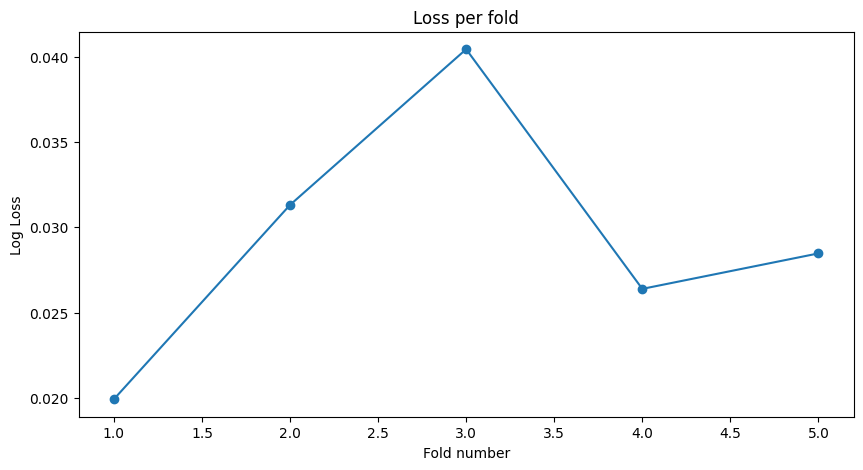

In [ ]:
# Assuming df is your DataFrame and it has a column named 'label'
X = df_test.drop("label", axis=1)  # replace 'features' with your actual feature columns
y = df_test['label']

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

loss_values = []
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Initialize LGBMClassifier
    model = lgb.LGBMClassifier()

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict_proba(X_test)

    # Calculate loss
    loss = log_loss(y_test, y_pred)
    loss_values.append(loss)
    print(f'Loss for fold {i+1}: {loss}')

    # Save the model
    joblib.dump(model, data_path+f'model2_fold_{i+1}.joblib')

# Plot the loss values
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o')
plt.title('Loss per fold')
plt.xlabel('Fold number')
plt.ylabel('Log Loss')
plt.show()

In [141]:
df_anno_temp = df_anno[["rare_C_counts", "rare_NC_counts", "C_counts", "NC_counts", "C_percent", "NC_percent", "weighted_C_percent", "weighted_NC_percent"]]

In [142]:
models = []
for i in range(5):
    models.append(joblib.load(data_path+f'model2_fold_{i+1}.joblib'))

predictions = []
for model in models:
    predictions.append(model.predict_proba(df_anno_temp))

df_anno[['prediction2_C', 'prediction2_NC']] = np.mean(predictions, axis=0)

In [ ]:
df_anno[df_anno.label_agenda=="C"].describe()

,rare_C_counts,rare_NC_counts,C_counts,NC_counts,gen_counts,counts,C_percent,NC_percent,weighted_C_percent,weighted_NC_percent,prediction2_C,prediction2_NC
count,2271.000000,2271.000000,2271.000000,2271.000000,2271.000000,2271.000000,2271.000000,2271.000000,2271.000000,2271.000000,2271.000000,2271.000000
mean,0.533686,0.062968,3.759137,0.227653,16.312197,80.085865,4.330411,0.287792,5.486249,0.365904,0.707631,0.292369
std,1.606865,0.351207,6.513600,0.723825,16.455141,85.194673,4.692851,1.037143,5.924895,1.329917,0.432797,0.432797
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000004,0.000087
25%,0.000000,0.000000,0.000000,0.000000,7.000000,36.500000,0.000000,0.000000,0.000000,0.000000,0.000712,0.000989
50%,0.000000,0.000000,2.000000,0.000000,11.000000,53.000000,3.125000,0.000000,4.000000,0.000000,0.998539,0.001461
75%,0.000000,0.000000,4.000000,0.000000,18.000000,78.000000,6.666667,0.000000,8.333333,0.000000,0.999011,0.999288
max,20.000000,5.000000,91.000000,9.000000,128.000000,810.000000,38.095238,13.333333,42.105263,16.666667,0.999913,0.999996


In [ ]:
df_anno

,label_agenda,processed_tokens,processed_tokens_lemma,id,rare_C_counts,rare_NC_counts,C_counts,NC_counts,gen_counts,counts,tokenized_speech,C_percent,NC_percent,weighted_C_percent,weighted_NC_percent,prediction2_C,prediction2_NC
0,C,"['spørgsmålet', 'lyder', 'ministeren', 'statsm...","['spørgsmål', 'lyde', 'minister', 'statsminist...",22_16_2,0,0,0,0,3,20,"[spørgsmålet, lyder, ministeren, statsminister...",0.000000,0.0,0.000000,0.0,0.000712,0.999288
1,C,"['tak', 'spørgsmålet', 'starte', 'slå', 'fast'...","['tak', 'spørgsmål', 'starte', 'slå', 'fast', ...",22_16_4,0,0,6,0,10,75,"[tak, spørgsmålet, starte, slå, fast, regering...",8.000000,0.0,9.230769,0.0,0.998946,0.001054
2,C,"['virkeligheden', 'kloden', 'behov', 'initiati...","['virkelighed', 'klod', 'behov', 'initiativ', ...",22_16_6,0,0,3,0,15,69,"[virkeligheden, kloden, behov, initiativer, kl...",4.347826,0.0,5.555556,0.0,0.998919,0.001081
3,C,"['selvfølgelig', 'vanskeligt', 'filosofere', '...","['selvfølgelig', 'vanskelig', 'filosofere', 'h...",22_16_8,0,0,0,0,31,103,"[selvfølgelig, vanskeligt, filosofere, hjælpe,...",0.000000,0.0,0.000000,0.0,0.000712,0.999288
4,C,"['jamen', 'virkeligheden', 'netop', 'står', 'f...","['jamen', 'virkelighed', 'netop', 'stå', 'fast...",22_16_10,0,0,1,0,17,59,"[jamen, virkeligheden, netop, står, fast, eu, ...",1.694915,0.0,2.380952,0.0,0.999111,0.000889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37689,NC,"['indrømme', 'står', 'forsøger', 'kreativ', 'h...","['indrømme', 'stå', 'forsøge', 'kreativ', 'hen...",1787_16_2,0,0,0,0,13,86,"[indrømme, står, forsøger, kreativ, henblik, f...",0.000000,0.0,0.000000,0.0,0.000712,0.999288
37690,NC,"['medgiver', 'forvirrende', 'foregående', 'spø...","['medgive', 'forvirre', 'foregående', 'spørgsm...",1787_16_4,0,0,0,0,10,46,"[medgiver, forvirrende, foregående, spørgsmål,...",0.000000,0.0,0.000000,0.0,0.000712,0.999288
37691,NC,"['forventer', 'møde', 'afholdes', 'inden', 'må...","['forvente', 'møde', 'afholde', 'inden', 'måne...",1787_16_6,0,0,0,0,0,7,"[forventer, møde, afholdes, inden, måneds, tid...",0.000000,0.0,0.000000,0.0,0.000712,0.999288
37692,NC,"['bare', 'ministeren', 'nuværende', 'tidspunkt...","['bare', 'minister', 'nuværende', 'tidspunkt',...",1787_16_8,0,0,0,0,8,26,"[bare, ministeren, nuværende, tidspunkt, set, ...",0.000000,0.0,0.000000,0.0,0.000712,0.999288


In [ ]:
#del df_anno["processed_tokens_lemma"], df_anno["rare_C_counts"], df_anno["rare_NC_counts"], df_anno["C_counts"], df_anno["NC_counts"], df_anno["C_percent"], df_anno["NC_percent"], df_anno["weighted_C_percent"], df_anno["weighted_NC_percent"], df_anno["prediction2_NC"], df_anno["gen_counts"], df_anno["counts"], df_anno["tokenized_speech"]

In [ ]:
df_anno

,label_agenda,processed_tokens,id,prediction2_C
0,C,"['spørgsmålet', 'lyder', 'ministeren', 'statsm...",22_16_2,0.000712
1,C,"['tak', 'spørgsmålet', 'starte', 'slå', 'fast'...",22_16_4,0.998946
2,C,"['virkeligheden', 'kloden', 'behov', 'initiati...",22_16_6,0.998919
3,C,"['selvfølgelig', 'vanskeligt', 'filosofere', '...",22_16_8,0.000712
4,C,"['jamen', 'virkeligheden', 'netop', 'står', 'f...",22_16_10,0.999111
...,...,...,...,...
37689,NC,"['indrømme', 'står', 'forsøger', 'kreativ', 'h...",1787_16_2,0.000712
37690,NC,"['medgiver', 'forvirrende', 'foregående', 'spø...",1787_16_4,0.000712
37691,NC,"['forventer', 'møde', 'afholdes', 'inden', 'må...",1787_16_6,0.000712
37692,NC,"['bare', 'ministeren', 'nuværende', 'tidspunkt...",1787_16_8,0.000712


In [93]:
len(rare_C_words)

57

In [92]:
len(C_words)

196

In [ ]:
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6]

for threshold in thresholds:
  df_anno["label_predicted"] = df_anno["prediction2_C"].apply(lambda x: "C" if x >= threshold else "NC")

  cm = confusion_matrix(df_anno.label_agenda.to_list(), df_anno.label_predicted.to_list())
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  print(f"Confusion Matrix with threshold {threshold}:")
  print(cm)
  print(f"Confusion Matrix (Normalized by row sums) with threshold {threshold}:")
  print(cm_normalized)

Confusion Matrix with threshold 0.2:
[[ 1678   593]
 [ 1716 33707]]
Confusion Matrix (Normalized by row sums) with threshold 0.2:
[[0.73888155 0.26111845]
 [0.0484431  0.9515569 ]]
Confusion Matrix with threshold 0.3:
[[ 1677   594]
 [ 1652 33771]]
Confusion Matrix (Normalized by row sums) with threshold 0.3:
[[0.73844122 0.26155878]
 [0.04663637 0.95336363]]
Confusion Matrix with threshold 0.4:
[[ 1668   603]
 [ 1626 33797]]
Confusion Matrix (Normalized by row sums) with threshold 0.4:
[[0.7344782  0.2655218 ]
 [0.04590238 0.95409762]]
Confusion Matrix with threshold 0.5:
[[ 1643   628]
 [ 1610 33813]]
Confusion Matrix (Normalized by row sums) with threshold 0.5:
[[0.72346984 0.27653016]
 [0.0454507  0.9545493 ]]
Confusion Matrix with threshold 0.6:
[[ 1617   654]
 [ 1609 33814]]
Confusion Matrix (Normalized by row sums) with threshold 0.6:
[[0.71202114 0.28797886]
 [0.04542247 0.95457753]]


In [136]:
3200/(33800+3200+654)

0.0849843310139693

In [ ]:
df_anno[(df_anno["label_agenda"] == "NC") & (df_anno["label_predicted"] == "C")]

,label_agenda,processed_tokens,id,prediction2_C,label_predicted
2582,NC,"['t', 'asfalt', 'ensbetydende', 'får', 'ændret...",13_6_2,0.996037,C
2583,NC,"['udbygningen', 'km', 'omfartsvej', 'brande', ...",13_6_4,0.997428,C
2585,NC,"['lovforslaget', 'udbygning', 'brande', 'omfar...",13_6_8,0.998576,C
2587,NC,"['radikale', 'ordfører', 'stede', 'meddele', '...",13_6_12,0.998014,C
2588,NC,"['nordjyde', 'særlig', 'forkærlighed', 'motorv...",13_6_14,0.995616,C
...,...,...,...,...,...
37392,NC,"['naturligvis', 'beklage', 'besidder', 'større...",1768_16_10,0.997616,C
37393,NC,"['interessant', 'skatteministeren', 'stand', '...",1768_16_12,0.998742,C
37394,NC,"['per', 'clausen', 'kører', 'niveau', 'slet', ...",1768_16_14,0.997023,C
37605,NC,"['starten', 'dansk', 'folkeparti', 'skatterefo...",1782_17_46,0.998926,C


In [ ]:
df_anno[(df_anno["label_agenda"] == "C") & (df_anno["label_predicted"] == "NC")]

,label_agenda,processed_tokens,id,prediction2_C,label_predicted
0,C,"['spørgsmålet', 'lyder', 'ministeren', 'statsm...",22_16_2,0.000712,NC
3,C,"['selvfølgelig', 'vanskeligt', 'filosofere', '...",22_16_8,0.000712,NC
6,C,"['tro', 'regeringen', 'slet', 'stede', 'klimat...",22_16_14,0.000712,NC
8,C,"['tak', 'lade', 'stå', 'begynde', 'læse', 'spø...",22_18_2,0.000712,NC
10,C,"['sammenfattes', 'regeringen', 'mener', 'danma...",22_18_6,0.000712,NC
...,...,...,...,...,...
2255,C,"['tak', 'bede', 'jørn', 'dohrmann', 'kigge', '...",1782_14_44,0.000712,NC
2266,C,"['tak', 'gerne', 'fortsætte', 'rosen', 'egentl...",1782_14_66,0.000712,NC
2267,C,"['konservative', 'ordfører', 'forstå', 'måde',...",1782_14_68,0.000712,NC
2268,C,"['grunden', 'spørger', 'set', 'absolut', 'hist...",1782_14_70,0.000712,NC


### Back to Square 1

In [105]:
df1 = pd.read_csv(data_path+"train_df1.csv")
df2 = pd.read_csv(data_path+"train_df2.csv")
df3 = pd.read_csv(data_path+"train_df3.csv")

In [106]:
from gensim.models import KeyedVectors
MODEL_FILE = 'dsl_skipgram_2020_m5_f500_epoch2_w5.model.w2v.bin'
model = KeyedVectors.load_word2vec_format(data_path+MODEL_FILE, binary=True)

In [107]:
for df in [df1, df2, df3]:
  count_list = []
  speech_list = []
  word_vec_list = []

  tokenized_list = df.tokenized_speech.to_list()
  for i in tokenized_list:
    rare_C_counts = 0
    rare_NC_counts = 0
    C_counts = 0
    NC_counts = 0
    generic_counts = 0
    average_vec = 0

    tokenized = eval(i)
    token_len = len(tokenized)
    for word in tokenized:
      if word in generic_words_set:
        generic_counts += 1
        token_len -= 1
      else:
        if word in rare_C_words:
          rare_C_counts += 1
        elif word in rare_NC_words:
          rare_NC_counts += 1
        elif word in C_words:
          C_counts += 1
        elif word in NC_words:
          NC_counts += 1

        try:
          vec = model.get_vector(word)
          average_vec += vec
        except:
          token_len -= 1

    count_list.append([rare_C_counts, rare_NC_counts, C_counts, NC_counts, generic_counts, len(tokenized)])
    speech_list.append(tokenized)
    if token_len != 0:
      average_vec = average_vec/token_len
    else:
      average_vec = np.zeros((500,), dtype=int)
    word_vec_list.append(average_vec)

  df[["rare_C_counts", "rare_NC_counts", "C_counts", "NC_counts", "gen_counts", "counts"]] = count_list
  df["tokenized_speech"] = speech_list
  df["average_vec"] = word_vec_list

  df["C_percent"] = 100 * df['C_counts'] / df["counts"]
  df["NC_percent"] = 100 * df['NC_counts'] / df["counts"]
  df["weighted_C_percent"] = 100 * df['C_counts'] / (df["counts"] - df["gen_counts"])
  df["weighted_NC_percent"] = 100 * df['NC_counts'] / (df["counts"] - df["gen_counts"])

In [108]:
df1_temp = df1[["rare_C_counts", "rare_NC_counts", "C_counts", "NC_counts", "C_percent", "NC_percent", "weighted_C_percent", "weighted_NC_percent"]]
df2_temp = df2[["rare_C_counts", "rare_NC_counts", "C_counts", "NC_counts", "C_percent", "NC_percent", "weighted_C_percent", "weighted_NC_percent"]]
df3_temp = df3[["rare_C_counts", "rare_NC_counts", "C_counts", "NC_counts", "C_percent", "NC_percent", "weighted_C_percent", "weighted_NC_percent"]]

In [109]:
import joblib

In [110]:
models = []
for i in range(5):
    models.append(joblib.load(data_path+f'model2_fold_{i+1}.joblib'))

predictions1 = []
predictions2 = []
predictions3 = []
for model in models:
    predictions1.append(model.predict_proba(df1_temp))
    predictions2.append(model.predict_proba(df2_temp))
    predictions3.append(model.predict_proba(df3_temp))

df1[['prediction2_C', 'prediction2_NC']] = np.mean(predictions1, axis=0)
df2[['prediction2_C', 'prediction2_NC']] = np.mean(predictions2, axis=0)
df3[['prediction2_C', 'prediction2_NC']] = np.mean(predictions3, axis=0)

In [111]:
df1[(df1.rare_C_counts==0)&(df1.C_counts==0)&(df1.rare_NC_counts==0)&(df1.NC_counts==0)].describe()

,prediction_C,rare_C_counts,rare_NC_counts,C_counts,NC_counts,gen_counts,counts,C_percent,NC_percent,weighted_C_percent,weighted_NC_percent,prediction2_C,prediction2_NC
count,37614.000000,37614.0,37614.0,37614.0,37614.0,37614.000000,37614.000000,37593.0,37593.0,37550.0,37550.0,3.761400e+04,3.761400e+04
mean,0.099993,0.0,0.0,0.0,0.0,10.369836,48.262881,0.0,0.0,0.0,0.0,7.118244e-04,9.992882e-01
std,0.186069,0.0,0.0,0.0,0.0,7.704493,33.737518,0.0,0.0,0.0,0.0,2.168433e-19,1.110238e-16
min,0.000025,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,7.118244e-04,9.992882e-01
25%,0.003750,0.0,0.0,0.0,0.0,5.000000,27.000000,0.0,0.0,0.0,0.0,7.118244e-04,9.992882e-01
50%,0.018585,0.0,0.0,0.0,0.0,9.000000,44.000000,0.0,0.0,0.0,0.0,7.118244e-04,9.992882e-01
75%,0.094572,0.0,0.0,0.0,0.0,14.000000,62.000000,0.0,0.0,0.0,0.0,7.118244e-04,9.992882e-01
max,0.999519,0.0,0.0,0.0,0.0,111.000000,789.000000,0.0,0.0,0.0,0.0,7.118244e-04,9.992882e-01


In [112]:
df1[~((df1.rare_C_counts==0)&(df1.C_counts==0)&(df1.rare_NC_counts==0)&(df1.NC_counts==0))].describe()

,prediction_C,rare_C_counts,rare_NC_counts,C_counts,NC_counts,gen_counts,counts,C_percent,NC_percent,weighted_C_percent,weighted_NC_percent,prediction2_C,prediction2_NC
count,71092.000000,71092.000000,71092.000000,71092.000000,71092.000000,71092.000000,71092.000000,71092.000000,71092.000000,71092.000000,71092.000000,71092.000000,71092.000000
mean,0.107439,0.043324,1.896711,0.709011,2.082808,18.779342,97.542382,0.822122,2.346462,1.041174,2.966677,0.132920,0.867080
std,0.271692,0.406696,3.401221,2.856568,3.701554,18.883837,105.597372,2.459249,2.914732,3.111799,3.737873,0.332244,0.332244
min,0.000015,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000003,0.000064
25%,0.000171,0.000000,0.000000,0.000000,0.000000,9.000000,46.000000,0.000000,0.000000,0.000000,0.000000,0.000009,0.999971
50%,0.000970,0.000000,1.000000,0.000000,1.000000,13.000000,66.000000,0.000000,1.515152,0.000000,1.923077,0.000012,0.999988
75%,0.013079,0.000000,2.000000,0.000000,2.000000,21.000000,95.000000,0.000000,3.508772,0.000000,4.419890,0.000029,0.999991
max,0.999887,24.000000,80.000000,125.000000,120.000000,390.000000,2351.000000,50.000000,33.333333,50.000000,100.000000,0.999936,0.999997


In [176]:
df = pd.concat([df1, df2, df3]).reset_index(drop=True)

In [124]:
df_train = df[~((df.rare_C_counts==0)&(df.C_counts==0)&(df.rare_NC_counts==0)&(df.NC_counts==0))]

In [130]:
df_trash = df[(df.rare_C_counts==0)&(df.C_counts==0)&(df.rare_NC_counts==0)&(df.NC_counts==0)]

In [173]:
df_trash

,id,tokenized_speech,prediction_C,rare_C_counts,rare_NC_counts,C_counts,NC_counts,gen_counts,counts,average_vec,C_percent,NC_percent,weighted_C_percent,weighted_NC_percent,prediction2_C,prediction2_NC
0,1_1_1,"[tak, transportminister, optaget, fik, sikkerh...",0.627630,0,0,0,0,5,40,"[-0.072632745, 0.018109301, -0.025095398, -0.1...",0.0,0.0,0.0,0.0,0.000712,0.999288
1,1_1_3,"[jamen, godt, spørgsmål, fyn, taler, penge, br...",0.084370,0,0,0,0,6,32,"[-0.06632821, 0.043316524, 0.05172416, -0.1404...",0.0,0.0,0.0,0.0,0.000712,0.999288
2,1_1_5,"[glad, høre, transportminister, mente, rent, f...",0.180484,0,0,0,0,9,60,"[-0.021982169, -0.007825997, 0.02033437, -0.15...",0.0,0.0,0.0,0.0,0.000712,0.999288
3,1_1_7,"[jamen, spørgeren, siger, klart, forhandlinger...",0.025299,0,0,0,0,2,15,"[-0.048956268, 0.015759718, -0.029212598, -0.1...",0.0,0.0,0.0,0.0,0.000712,0.999288
4,1_1_9,"[rent, spark, sparker, åben, dør, siger, tak, ...",0.008243,0,0,0,0,2,8,"[-0.034080017, 0.051288128, 0.16791177, 0.0030...",0.0,0.0,0.0,0.0,0.000712,0.999288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329797,1787_22_12,"[læst, børsen, nationalmuseet, statens, museum...",0.009200,0,0,0,0,1,18,"[0.018043984, 0.015812064, 0.048341323, -0.085...",0.0,0.0,0.0,0.0,0.000712,0.999288
329798,1787_22_14,"[læst, artikel, børsen, gerne, kigge, leif, la...",0.067142,0,0,0,0,2,10,"[-0.22619496, 0.047462896, 0.11196743, -0.0870...",0.0,0.0,0.0,0.0,0.000712,0.999288
329799,1787_22_16,"[set, svar, ministeren, ministeren, kunnet, ge...",0.015955,0,0,0,0,18,52,"[-0.09864959, 0.068410836, 0.024919875, -0.174...",0.0,0.0,0.0,0.0,0.000712,0.999288
329800,1787_22_18,"[kulturinstitutionerne, helhed, mærket, forrin...",0.001473,0,0,0,0,15,68,"[-0.030219702, 0.04983628, 0.07967779, -0.1363...",0.0,0.0,0.0,0.0,0.000712,0.999288


In [131]:
df_trash.describe()

,prediction_C,rare_C_counts,rare_NC_counts,C_counts,NC_counts,gen_counts,counts,C_percent,NC_percent,weighted_C_percent,weighted_NC_percent,prediction2_C,prediction2_NC
count,115469.000000,115469.0,115469.0,115469.0,115469.0,115469.000000,115469.000000,115399.0,115399.0,115210.0,115210.0,1.154690e+05,1.154690e+05
mean,0.099141,0.0,0.0,0.0,0.0,9.936173,45.445037,0.0,0.0,0.0,0.0,7.118244e-04,9.992882e-01
std,0.185363,0.0,0.0,0.0,0.0,7.397226,32.347660,0.0,0.0,0.0,0.0,2.168414e-19,4.440911e-16
min,0.000025,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,7.118244e-04,9.992882e-01
25%,0.003597,0.0,0.0,0.0,0.0,5.000000,26.000000,0.0,0.0,0.0,0.0,7.118244e-04,9.992882e-01
50%,0.018270,0.0,0.0,0.0,0.0,9.000000,41.000000,0.0,0.0,0.0,0.0,7.118244e-04,9.992882e-01
75%,0.093529,0.0,0.0,0.0,0.0,13.000000,58.000000,0.0,0.0,0.0,0.0,7.118244e-04,9.992882e-01
max,0.999519,0.0,0.0,0.0,0.0,118.000000,789.000000,0.0,0.0,0.0,0.0,7.118244e-04,9.992882e-01


In [125]:
df_train.describe()

,prediction_C,rare_C_counts,rare_NC_counts,C_counts,NC_counts,gen_counts,counts,C_percent,NC_percent,weighted_C_percent,weighted_NC_percent,prediction2_C,prediction2_NC
count,214334.000000,214334.000000,214334.000000,214334.000000,214334.000000,214334.000000,214334.000000,214334.000000,214334.000000,214334.000000,214334.000000,214334.000000,214334.000000
mean,0.106677,0.040666,1.951800,0.724145,2.039448,18.482159,95.507381,0.860759,2.347332,1.092930,2.978757,0.134610,0.865390
std,0.270272,0.409192,3.576083,2.902067,3.698940,19.015947,107.053057,2.540263,2.970510,3.230706,3.814358,0.334072,0.334072
min,0.000015,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000003,0.000064
25%,0.000169,0.000000,0.000000,0.000000,0.000000,8.000000,43.000000,0.000000,0.000000,0.000000,0.000000,0.000009,0.999972
50%,0.000943,0.000000,1.000000,0.000000,1.000000,13.000000,62.000000,0.000000,1.526718,0.000000,1.923077,0.000012,0.999988
75%,0.012732,0.000000,2.000000,0.000000,2.000000,20.000000,93.000000,0.000000,3.508772,0.000000,4.444444,0.000028,0.999991
max,0.999887,33.000000,91.000000,125.000000,121.000000,411.000000,2643.000000,50.000000,100.000000,100.000000,100.000000,0.999936,0.999997


In [160]:
df_train[(df_train.prediction2_C>0.99)].describe()

,prediction_C,rare_C_counts,rare_NC_counts,C_counts,NC_counts,gen_counts,counts,C_percent,NC_percent,weighted_C_percent,weighted_NC_percent,prediction2_C,prediction2_NC
count,26437.000000,26437.000000,26437.000000,26437.000000,26437.000000,26437.000000,26437.000000,26437.000000,26437.000000,26437.000000,26437.000000,26437.000000,26437.000000
mean,0.644320,0.270757,0.003934,3.683323,0.006468,15.153270,73.688089,5.474400,0.002412,6.984571,0.002924,0.998692,0.001308
std,0.371903,1.069882,0.083335,5.258483,0.134452,13.773258,70.596835,4.491825,0.052533,5.722119,0.062997,0.000769,0.000769
min,0.000050,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.990186,0.000064
25%,0.276813,0.000000,0.000000,1.000000,0.000000,8.000000,39.000000,2.247191,0.000000,2.857143,0.000000,0.998485,0.000953
50%,0.814182,0.000000,0.000000,2.000000,0.000000,12.000000,55.000000,4.166667,0.000000,5.263158,0.000000,0.998832,0.001168
75%,0.987210,0.000000,0.000000,4.000000,0.000000,17.000000,77.000000,7.407407,0.000000,9.433962,0.000000,0.999047,0.001515
max,0.999887,33.000000,4.000000,121.000000,11.000000,174.000000,1408.000000,50.000000,3.658537,100.000000,4.109589,0.999936,0.009814


In [186]:
df_train[(df_train.prediction2_C<0.1)&(df_train.C_counts==0)].describe()

,prediction_C,rare_C_counts,rare_NC_counts,C_counts,NC_counts,gen_counts,counts,C_percent,NC_percent,weighted_C_percent,weighted_NC_percent,prediction2_C,prediction2_NC
count,171364.000000,171364.000000,171364.000000,171364.0,171364.000000,171364.000000,171364.000000,171364.0,171364.000000,171364.0,171364.000000,171364.000000,171364.000000
mean,0.013009,0.000280,2.145503,0.0,2.214041,17.277112,88.184333,0.0,2.762878,0.0,3.511450,0.000020,0.999980
std,0.060736,0.019019,3.404639,0.0,3.502118,16.247727,88.925739,0.0,3.093001,0.0,3.980264,0.000620,0.000620
min,0.000015,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.000000,0.000003,0.901512
25%,0.000130,0.000000,0.000000,0.0,0.000000,8.000000,43.000000,0.0,0.000000,0.0,0.000000,0.000008,0.999986
50%,0.000531,0.000000,1.000000,0.0,1.000000,13.000000,60.000000,0.0,2.000000,0.0,2.500000,0.000011,0.999989
75%,0.003027,0.000000,3.000000,0.0,3.000000,20.000000,88.000000,0.0,4.035874,0.0,5.128205,0.000014,0.999992
max,0.999466,2.000000,78.000000,0.0,121.000000,336.000000,1903.000000,0.0,100.000000,0.0,100.000000,0.098488,0.999997


In [167]:
df_C = df_train.loc[(df_train.prediction2_C>0.99), ["average_vec"]]
df_C["label"] = "C"

df_NC = df_train.loc[(df_train.prediction2_C<0.1)&(df_train.C_counts==0), ["average_vec"]]
df_NC["label"] = "NC"

In [168]:
df_test = pd.concat([df_C, df_NC])
df_temp = df_test['average_vec'].apply(lambda x: pd.Series(x))
df_test = pd.concat([df_temp, df_test["label"]], axis=1).reset_index(drop=True)

In [169]:
df_test

,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,label
0,-0.027987,0.051431,-0.053294,-0.178021,-0.079642,0.051583,-0.008029,0.102490,0.049324,-0.075826,...,0.080195,-0.077774,-0.008437,0.025220,-0.156814,0.046338,-0.052233,0.041661,0.066176,C
1,-0.005338,-0.008429,0.035599,-0.133842,-0.126732,0.034058,-0.159773,0.122517,0.156440,-0.006262,...,0.154832,-0.040302,0.079098,-0.029008,-0.111907,0.041304,-0.022959,-0.044681,0.065339,C
2,-0.072197,-0.021740,0.051306,-0.120508,-0.066720,0.069958,-0.157487,0.052661,0.139032,-0.019046,...,0.139356,-0.092200,0.045136,-0.017861,-0.088754,-0.007491,-0.097426,-0.007143,0.046529,C
3,-0.080490,0.010626,0.020832,-0.076224,-0.081617,0.066352,-0.066049,0.019115,0.083283,-0.038032,...,0.060298,-0.090697,0.017021,-0.039643,-0.105480,0.055892,-0.000681,0.007427,0.045398,C
4,-0.105000,-0.034018,-0.052935,-0.136211,-0.069624,0.037149,-0.070705,0.048471,0.098784,0.012310,...,0.113035,-0.085604,0.028463,-0.090399,-0.100006,0.090538,0.018649,0.067950,0.010142,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197796,-0.000952,0.038930,0.115081,-0.080982,-0.083055,0.057670,-0.061072,-0.035867,0.165954,-0.101560,...,0.112080,-0.079707,0.086824,-0.052944,-0.220157,-0.089537,-0.073027,-0.006551,0.042468,NC
197797,-0.054352,0.054739,0.057712,-0.119902,-0.010967,0.028123,-0.079493,-0.034714,0.151911,-0.108944,...,0.132281,-0.140774,0.024862,-0.096176,-0.121971,-0.001447,-0.112533,0.035216,-0.025308,NC
197798,0.023461,0.044302,0.103140,-0.063242,-0.028275,0.037768,-0.058394,-0.013348,0.100115,-0.086207,...,0.126548,-0.114024,0.029085,-0.079630,-0.128137,-0.083994,-0.113427,-0.016021,-0.000725,NC
197799,-0.037540,0.065176,0.056532,-0.085336,-0.128525,0.048363,-0.084704,-0.016561,0.164532,-0.089549,...,0.087026,-0.077941,0.043042,0.038942,-0.147527,-0.008387,-0.032127,0.020390,0.063380,NC


[LightGBM] [Info] Number of positive: 137091, number of negative: 21149
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.751873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127500
[LightGBM] [Info] Number of data points in the train set: 158240, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.866349 -> initscore=1.869052
[LightGBM] [Info] Start training from score 1.869052
Loss for fold 1: 0.0952267723443009
[LightGBM] [Info] Number of positive: 137092, number of negative: 21149
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.860098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127500
[LightGBM] [Info] Number of data points in the train set: 158241, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.866349 -> initscore=1.869060
[LightGBM] [Info] Start

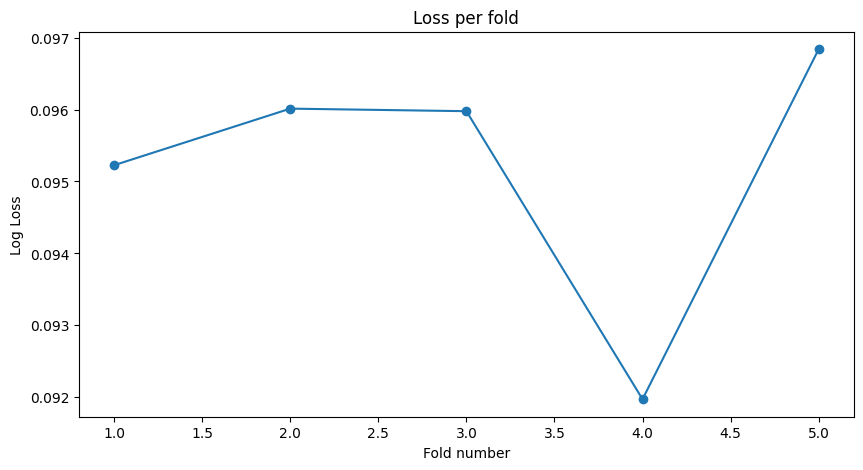

In [170]:
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, log_loss
import joblib

# Assuming df is your DataFrame and it has a column named 'label'
X = df_test.drop("label", axis=1)  # replace 'features' with your actual feature columns
y = df_test['label']

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

loss_values = []
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Initialize LGBMClassifier
    model = lgb.LGBMClassifier()

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict_proba(X_test)

    # Calculate loss
    loss = log_loss(y_test, y_pred)
    loss_values.append(loss)
    print(f'Loss for fold {i+1}: {loss}')

    # Save the model
    joblib.dump(model, data_path+f'model3_fold_{i+1}.joblib')

# Plot the loss values
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o')
plt.title('Loss per fold')
plt.xlabel('Fold number')
plt.ylabel('Log Loss')
plt.show()

In [179]:
df_temp = df['average_vec'].apply(lambda x: pd.Series(x))

In [180]:
models = []
for i in range(5):
    models.append(joblib.load(data_path+f'model3_fold_{i+1}.joblib'))

predictions1 = []
for model in models:
    predictions1.append(model.predict_proba(df_temp))

df[['prediction3_C', 'prediction3_NC']] = np.mean(predictions1, axis=0)

In [182]:
df.describe()

,prediction_C,rare_C_counts,rare_NC_counts,C_counts,NC_counts,gen_counts,counts,C_percent,NC_percent,weighted_C_percent,weighted_NC_percent,prediction2_C,prediction2_NC,prediction3_C,prediction3_NC
count,329803.000000,329803.000000,329803.000000,329803.000000,329803.000000,329803.000000,329803.000000,329733.000000,329733.000000,329544.000000,329544.000000,329803.000000,329803.000000,329803.000000,329803.000000
mean,0.104039,0.026428,1.268445,0.470611,1.325406,15.490080,77.979800,0.559513,1.525820,0.710837,1.937371,0.087730,0.912270,0.155321,0.844679
std,0.243957,0.330442,3.029481,2.364875,3.136592,16.455323,91.566952,2.088804,2.643716,2.657081,3.388268,0.276784,0.276784,0.270501,0.270501
min,0.000015,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,0.000064,0.000276,0.000086
25%,0.000358,0.000000,0.000000,0.000000,0.000000,7.000000,36.000000,0.000000,0.000000,0.000000,0.000000,0.000011,0.999288,0.006104,0.858007
50%,0.003267,0.000000,0.000000,0.000000,0.000000,11.000000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000031,0.999969,0.029210,0.970790
75%,0.042107,0.000000,1.000000,0.000000,1.000000,17.000000,78.000000,0.000000,2.272727,0.000000,2.857143,0.000712,0.999989,0.141993,0.993896
max,0.999887,33.000000,91.000000,125.000000,121.000000,411.000000,2643.000000,50.000000,100.000000,100.000000,100.000000,0.999936,0.999997,0.999914,0.999724


In [188]:
df[((df.rare_C_counts==0)&(df.C_counts==0)&(df.rare_NC_counts==0)&(df.NC_counts==0))].describe()

,prediction_C,rare_C_counts,rare_NC_counts,C_counts,NC_counts,gen_counts,counts,C_percent,NC_percent,weighted_C_percent,weighted_NC_percent,prediction2_C,prediction2_NC,prediction3_C,prediction3_NC
count,115469.000000,115469.0,115469.0,115469.0,115469.0,115469.000000,115469.000000,115399.0,115399.0,115210.0,115210.0,1.154690e+05,1.154690e+05,115469.000000,115469.000000
mean,0.099141,0.0,0.0,0.0,0.0,9.936173,45.445037,0.0,0.0,0.0,0.0,7.118244e-04,9.992882e-01,0.170115,0.829885
std,0.185363,0.0,0.0,0.0,0.0,7.397226,32.347660,0.0,0.0,0.0,0.0,2.168414e-19,4.440911e-16,0.207315,0.207315
min,0.000025,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,7.118244e-04,9.992882e-01,0.000381,0.000934
25%,0.003597,0.0,0.0,0.0,0.0,5.000000,26.000000,0.0,0.0,0.0,0.0,7.118244e-04,9.992882e-01,0.032694,0.779403
50%,0.018270,0.0,0.0,0.0,0.0,9.000000,41.000000,0.0,0.0,0.0,0.0,7.118244e-04,9.992882e-01,0.086935,0.913065
75%,0.093529,0.0,0.0,0.0,0.0,13.000000,58.000000,0.0,0.0,0.0,0.0,7.118244e-04,9.992882e-01,0.220597,0.967306
max,0.999519,0.0,0.0,0.0,0.0,118.000000,789.000000,0.0,0.0,0.0,0.0,7.118244e-04,9.992882e-01,0.999066,0.999619


In [193]:
df[((df.rare_C_counts==0)&(df.C_counts==0)&(df.rare_NC_counts==0)&(df.NC_counts==0))&(df.prediction3_C>0.9)].iloc[0].tokenized_speech

['jamen',
 'glad',
 'ting',
 'per',
 'clausen',
 'nævnte',
 'kunnet',
 'glæde',
 'dernæst',
 'spørgsmål',
 'sagt',
 'første',
 'går',
 'frederikssundmotorvejen',
 'nævnt',
 'al',
 'planlægning',
 'trafikprojekter',
 'foregår',
 'langt',
 'langsigtet',
 'tidsperspektiv',
 'tidsforløb',
 'bare',
 'nået',
 'dertil',
 'tidsforløb',
 'projekt',
 'nået',
 'frem',
 'frederikssundmotorvejen',
 'prøve',
 'se',
 'bort',
 'prøve',
 'se',
 'bort',
 'besluttet',
 'laves',
 'stor',
 'stor',
 'fejlvurdering',
 'enhedslistens',
 'side',
 'forstår',
 'godt',
 'enhedslisten',
 'interesse',
 'puha',
 'socialdemokraterne',
 'fæle',
 'ønsker',
 'kollektiv',
 'trafik',
 'bare',
 'fremme',
 'biltrafikken',
 'koncentrerer',
 'puha',
 'frederikssundmotorvejen',
 'ser',
 'hele',
 'forløb',
 'haft',
 'investeringer',
 'både',
 'hovedstadsområdet',
 'landet',
 'billedet',
 'helt',
 'helt',
 'anderledes',
 'enhedslisten',
 'forsøger',
 'tegne']

In [184]:
df[(~((df.rare_C_counts==0)&(df.C_counts==0)&(df.rare_NC_counts==0)&(df.NC_counts==0)))&(df.prediction2_C>0.99)].describe()

,prediction_C,rare_C_counts,rare_NC_counts,C_counts,NC_counts,gen_counts,counts,C_percent,NC_percent,weighted_C_percent,weighted_NC_percent,prediction2_C,prediction2_NC,prediction3_C,prediction3_NC
count,26437.000000,26437.000000,26437.000000,26437.000000,26437.000000,26437.000000,26437.000000,26437.000000,26437.000000,26437.000000,26437.000000,26437.000000,26437.000000,26437.000000,26437.000000
mean,0.644320,0.270757,0.003934,3.683323,0.006468,15.153270,73.688089,5.474400,0.002412,6.984571,0.002924,0.998692,0.001308,0.800985,0.199015
std,0.371903,1.069882,0.083335,5.258483,0.134452,13.773258,70.596835,4.491825,0.052533,5.722119,0.062997,0.000769,0.000769,0.263422,0.263422
min,0.000050,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.990186,0.000064,0.001785,0.000086
25%,0.276813,0.000000,0.000000,1.000000,0.000000,8.000000,39.000000,2.247191,0.000000,2.857143,0.000000,0.998485,0.000953,0.686763,0.007118
50%,0.814182,0.000000,0.000000,2.000000,0.000000,12.000000,55.000000,4.166667,0.000000,5.263158,0.000000,0.998832,0.001168,0.937409,0.062591
75%,0.987210,0.000000,0.000000,4.000000,0.000000,17.000000,77.000000,7.407407,0.000000,9.433962,0.000000,0.999047,0.001515,0.992882,0.313237
max,0.999887,33.000000,4.000000,121.000000,11.000000,174.000000,1408.000000,50.000000,3.658537,100.000000,4.109589,0.999936,0.009814,0.999914,0.998215


In [187]:
df[(~((df.rare_C_counts==0)&(df.C_counts==0)&(df.rare_NC_counts==0)&(df.NC_counts==0)))&(df.prediction2_C<0.1)&(df.C_counts==0)].describe()

,prediction_C,rare_C_counts,rare_NC_counts,C_counts,NC_counts,gen_counts,counts,C_percent,NC_percent,weighted_C_percent,weighted_NC_percent,prediction2_C,prediction2_NC,prediction3_C,prediction3_NC
count,171364.000000,171364.000000,171364.000000,171364.0,171364.000000,171364.000000,171364.000000,171364.0,171364.000000,171364.0,171364.000000,171364.000000,171364.000000,171364.000000,171364.000000
mean,0.013009,0.000280,2.145503,0.0,2.214041,17.277112,88.184333,0.0,2.762878,0.0,3.511450,0.000020,0.999980,0.030351,0.969649
std,0.060736,0.019019,3.404639,0.0,3.502118,16.247727,88.925739,0.0,3.093001,0.0,3.980264,0.000620,0.000620,0.071211,0.071211
min,0.000015,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.000000,0.000003,0.901512,0.000276,0.004255
25%,0.000130,0.000000,0.000000,0.0,0.000000,8.000000,43.000000,0.0,0.000000,0.0,0.000000,0.000008,0.999986,0.002700,0.974431
50%,0.000531,0.000000,1.000000,0.0,1.000000,13.000000,60.000000,0.0,2.000000,0.0,2.500000,0.000011,0.999989,0.007843,0.992157
75%,0.003027,0.000000,3.000000,0.0,3.000000,20.000000,88.000000,0.0,4.035874,0.0,5.128205,0.000014,0.999992,0.025569,0.997300
max,0.999466,2.000000,78.000000,0.0,121.000000,336.000000,1903.000000,0.0,100.000000,0.0,100.000000,0.098488,0.999997,0.995745,0.999724
